<a href="https://colab.research.google.com/github/Polineska/SpeechRecognition/blob/main/whisper_datasetRUGolos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dataset
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg
!pip install jiwer -q

In [ ]:
import os
import warnings
import whisper
import jiwer
import torch
import numpy as np
import pandas as pd

In [ ]:
!pip install datasets # Подключение датасетов
import sys
sys.executable
from datasets import load_dataset

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

In [ ]:
MODEL_ID = "base" #модель whisper (tiny, base, small, medium, large)
DATASET_ID = "bond005/sberdevices_golos_10h_crowd" #незашумленный датасет
#DATASET_ID = "bond005/sberdevices_golos_10h_crowd_noised_2db" #зашумленный датасет
SAMPLES = 9900 # кол-во строк из датасета

test_dataset = load_dataset(DATASET_ID, split=f"test[:{SAMPLES}]")
whisper_model = whisper.load_model(MODEL_ID)

# Функция для преобразования аудиофайлов в массивы
def speech_file_to_array_fn(batch):
    speech_array = batch["audio"]["array"]  # Извлекает массив аудиоданных из словаря batch
    batch["speech"] = speech_array # Добавляет массив аудиоданных в словарь batch под ключом "speech"
    return batch

# Предобработка датасета
removed_columns = set(test_dataset.column_names) # Удаление из множества столбцов, не относящихся к "transcription" и "speech"
removed_columns -= {'transcription', 'speech'} # Сортировка списока удаленных столбцов
removed_columns = sorted(list(removed_columns))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    test_dataset = test_dataset.map(
        speech_file_to_array_fn,
        remove_columns=removed_columns
    )

# Функция для распознавания речи с помощью Whisper
def infer_whisper(samples):
    transcripts = []
    for sample in samples:
        audio = np.array(sample["speech"], dtype=np.float32)  # Преобразование в numpy array
        audio = whisper.pad_or_trim(audio)  # Обработка аудиоданных
        mel = whisper.log_mel_spectrogram(audio).to(whisper_model.device) # Вычисление мел-спектрограммы
        decoding_result = whisper_model.decode(mel, fp16=torch.cuda.is_available(), language="ru")
        transcript_text = decoding_result.text # Извлечение текстовой расшифровки
        transcripts.append(transcript_text)
    return transcripts
# Распознавание речи и вывод результатов
hypotheses = infer_whisper(test_dataset)
references = test_dataset["transcription"]

tiny

In [ ]:
data_tiny = pd.DataFrame(dict(hypothesis_tiny=hypotheses, reference_tiny=references))
data_tiny

base

In [ ]:
data_base = pd.DataFrame(dict(hypothesis_base=hypotheses, reference_base=references))
data_base

,hypothesis_tiny,reference_tiny
0,"Солют, сколько предприятий изъебляются к резин...",салют сколько предприятий являются клиентами с...
1,Джой надоел.,джой надоел
2,"Солют, скажи время Московской и местные.",салют скажи время московское и местное
3,"Афина, я не хочу, чтобы сегодня звонил Гудвинник.",афина я не хочу чтобы сегодня звонил будильник
4,Солю позвоню Владимировым Петровичем.,салют позвони владимиру петровичу
...,...,...
1595,Афіна закруйся.,афина закройся
1596,"Joguljipa, Jalastro, Blinks, Thomas, Mcdlar, W...",джой включить пожалуйста блинк сто восемьдесят...
1597,"Джой, какие виды селепатия ты знаешь?",джой какие виды телепатия ты знаешь
1598,Почему я не нравлюсь девушкам?,почему я не нравлюсь девочкам


small

In [ ]:
data_small = pd.DataFrame(dict(hypothesis_small=hypotheses, reference_small=references))

medium

In [ ]:
data_medium = pd.DataFrame(dict(hypothesis_medium=hypotheses, reference_medium=references))

In [ ]:

import re
#нормализация текста
def normalize_text(text):
    if not isinstance(text, str):
        text = str(text)

    # Удаление знаков пунктуации и преобразование в нижний регистр
    text = re.sub(r'[^\w\s]', '', text).lower()

    # Удаление множественных пробелов
    text = re.sub(r'\s+', ' ', text)

    return text.strip()
normalized_refs = [normalize_text(ref) for ref in test_dataset["transcription"]]
normalized_hyps = [normalize_text(hyp) for hyp in hypotheses]
# Вычисление WER с нормализованными транскрипциями
wer_score = jiwer.wer(normalized_refs, normalized_hyps)
print(f"\nWord Error Rate: {wer_score * 100:.2f}%")


Word Error Rate: 66.88%


In [ ]:
data_tiny["hypothesis_tiny"] = [normalize_text(hyp) for hyp in hypotheses]
data_tiny["reference_tiny"] = [normalize_text(ref) for ref in test_dataset["transcription"]]
data_tiny
data_tiny["hypothesis_tiny"] = [normalizer(text) for text in data_tiny["hypothesis_tiny"]]
data_tiny["reference_tiny"] = [normalizer(text) for text in data_tiny["reference_tiny"]]
wer_tiny = jiwer.wer(list(data_tiny["reference_tiny"]), list(data_tiny["hypothesis_tiny"]))
print(f"wer_tiny: {wer_tiny * 100:.2f} %")

In [ ]:
data_base["hypothesis_base"] = [normalize_text(hyp) for hyp in hypotheses]
data_base["reference_base"] = [normalize_text(ref) for ref in test_dataset["transcription"]]
data_base
data_base["hypothesis_base"] = [normalizer(text) for text in data_base["hypothesis_base"]]
data_base["reference_base"] = [normalizer(text) for text in data_base["reference_base"]]
wer_base = jiwer.wer(list(data_base["reference_base"]), list(data_base["hypothesis_base"]))
print(f"wer_base: {wer_base * 100:.2f} %")

wer_base: 66.54 %


In [ ]:
data_small["hypothesis_small"] = [normalize_text(hyp) for hyp in hypotheses]
data_small["reference_small"] = [normalize_text(ref) for ref in test_dataset["transcription"]]
data_small
data_small["hypothesis_small"] = [normalizer(text) for text in data_small["hypothesis_small"]]
data_small["reference_small"] = [normalizer(text) for text in data_small["reference_small"]]
wer_small = jiwer.wer(list(data_small["reference_small"]), list(data_small["hypothesis_small"]))
print(f"wer_small: {wer_small * 100:.2f} %")

wer_small: 38.08 %


In [ ]:
data_medium["hypothesis_medium"] = [normalize_text(hyp) for hyp in hypotheses]
data_medium["reference_medium"] = [normalize_text(ref) for ref in test_dataset["transcription"]]
data_medium
data_medium["hypothesis_medium"] = [normalizer(text) for text in data_medium["hypothesis_medium"]]
data_medium["reference_medium"] = [normalizer(text) for text in data_medium["reference_medium"]]
wer_medium = jiwer.wer(list(data_medium["reference_medium"]), list(data_medium["hypothesis_medium"]))
print(f"wer_medium: {wer_medium * 100:.2f} %")

wer_medium: 26.25 %


WER

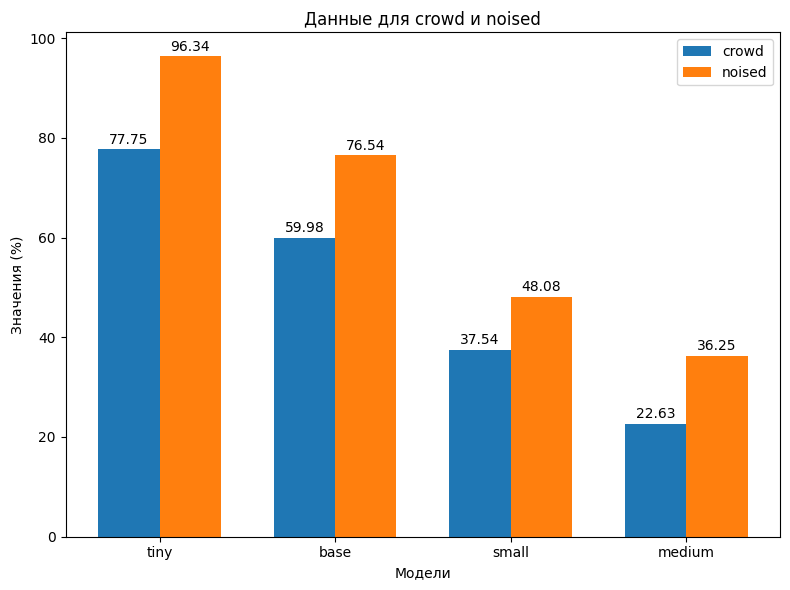

In [4]:
import matplotlib.pyplot as plt

# Данные
models = ['tiny', 'base', 'small', 'medium']
crowd = [77.75, 59.98, 37.54, 22.63]
noised = [96.34, 76.54, 48.08, 36.25]

# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(8, 6))

# Ширина столбцов
bar_width = 0.35

# Индексы для столбцов
index = range(len(models))

# Визуализация данных
bars1 = ax.bar(index, crowd, bar_width, label='crowd')
bars2 = ax.bar([i + bar_width for i in index], noised, bar_width, label='noised')

# Установка меток для осей
ax.set_xlabel('Модели')
ax.set_ylabel('Значения (%)')
ax.set_title('Данные для crowd и noised')

# Установка меток для столбцов
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)

# Легенда
ax.legend()

# Добавление значений на столбцах
for bar1, bar2, c, n in zip(bars1, bars2, crowd, noised):
    ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + 0.5, str(round(c, 2)), ha='center', va='bottom')
    ax.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() + 0.5, str(round(n, 2)), ha='center', va='bottom')

# Отображение графика
plt.tight_layout()
plt.show()